In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient

In [4]:
# Connexion à MongoDB et chargement des données
client = MongoClient("localhost", 27017)
db = client.IF29
collec = db.user_db_pca
data = pd.DataFrame(list(collec.find()))
print(data)
sample_data = data.sample(frac=0.02, random_state=42)

X = sample_data.drop(columns=['_id'])
Y= sample_data['_id'].copy()

                         _id      pca0      pca1      pca2      pca3  \
0                        418  7.031512  9.606121 -2.861546  2.035172   
1                        730 -0.178348  0.256096 -1.791521 -1.495685   
2                        761  1.448767 -0.128787 -2.363256 -0.287757   
3                        885  3.468847  5.987987 -4.033890  1.611682   
4                        922  0.440618  0.536790 -1.714077  0.029786   
...                      ...       ...       ...       ...       ...   
1843434  1008392352644386816 -1.135086  0.195285  1.388125 -0.008933   
1843435  1008392445837692933 -1.133827  0.194532  1.388737 -0.009059   
1843436  1008392594878066688 -1.113471  0.191946  1.527336  0.390469   
1843437  1008392729930366976 -1.136345  0.196039  1.387513 -0.008807   
1843438  1008392769428221952 -1.144907  0.207098  1.828799  0.845116   

             pca4      pca5      pca6      pca7      pca8  
0        0.062446 -0.620613  3.865267 -4.618006  0.345712  
1        0.5058

In [5]:
cah = linkage(X, method="ward")
print(cah)

[[3.12590000e+04 3.13230000e+04 0.00000000e+00 2.00000000e+00]
 [3.21300000e+03 2.13160000e+04 0.00000000e+00 2.00000000e+00]
 [4.72700000e+03 2.81000000e+04 0.00000000e+00 2.00000000e+00]
 ...
 [7.37300000e+04 7.37330000e+04 2.52015303e+02 3.65010000e+04]
 [7.37130000e+04 7.37320000e+04 2.63324563e+02 3.68000000e+02]
 [7.37340000e+04 7.37350000e+04 2.88391851e+02 3.68690000e+04]]


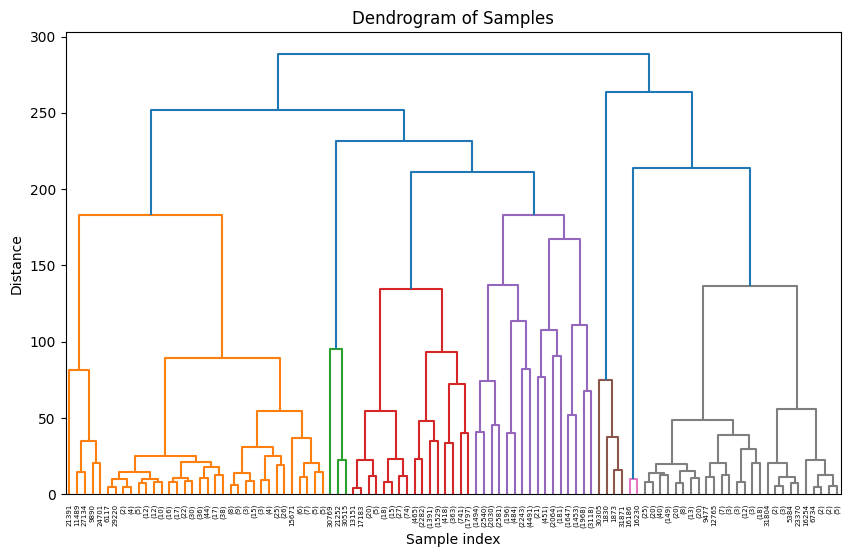

In [6]:
# Dendrogramme des échantillons
plt.figure(figsize=(10, 6))
dendrogram(cah, truncate_mode="level", p=7
           )
plt.title('Dendrogram of Samples')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [7]:
from sklearn.metrics import silhouette_score
# Fonction pour trouver le meilleur seuil max_d
def optimal_dendrogram_cut(cah, pca_res, min_clusters=2, max_clusters=10):
    best_silhouette_score = -1
    best_num_clusters = 0
    best_clusters = None

    for num_clusters in range(min_clusters, max_clusters + 1):
        # Utiliser fcluster pour couper le dendrogramme à num_clusters
        clusters = fcluster(cah, num_clusters, criterion='maxclust')
        
        # Calculer le score de silhouette pour les clusters
        silhouette_avg = silhouette_score(pca_res, clusters)
        
        # Comparer et garder le meilleur score de silhouette
        if silhouette_avg > best_silhouette_score:
            best_silhouette_score = silhouette_avg
            best_num_clusters = num_clusters
            best_clusters = clusters
            
    return best_num_clusters, best_clusters, best_silhouette_score

In [8]:
max_d = 50  # Vous pouvez ajuster ce seuil de distance selon vos besoins
clusters = fcluster(cah, max_d, criterion='distance')

In [9]:
result_df = pd.DataFrame({'_id': Y, 'cluster': clusters})

             pca0      pca1      pca2      pca3      pca4      pca5      pca6  \
1320333 -0.613096  0.255924  0.247878  1.312231 -0.564170 -0.028222  0.083482   
1791060 -0.681990  0.131012  0.510456  0.317264  0.105719  0.052627 -0.311428   
1399021 -0.695577  0.103242  0.568361 -0.370671  0.215751  0.065199 -0.290006   
263257   0.084417  0.056616 -0.960310  0.115785  0.394447  0.194650  0.009144   
1488643 -0.795611  0.165345  0.601635 -0.015405 -0.009464  0.075287 -0.214203   
...           ...       ...       ...       ...       ...       ...       ...   
950625  -0.475745  0.188952  0.541294  0.812588 -0.927173  0.464756 -0.663787   
1484071 -1.034671  0.214241  1.128840  0.030661 -0.147831  0.438005 -0.368874   
1511500 -0.764026  0.204774  0.553487  0.538232 -0.328196  0.239751 -0.356782   
1472074 -0.445897  0.064175  0.556621  0.875014 -0.382591  0.515209 -0.370623   
1255741 -0.802420  0.203742  0.510379  0.105445 -0.297885  0.372523 -0.348050   

             pca7      pca8

In [ ]:
# Charger les données de la base de données B pour la mise à jour
db_B = client['IF29']
collection_B = db_B['user_db']

# Mettre à jour les documents de la base de données B avec les étiquettes de cluster
for index, row in result_df.iterrows():
    id_value = row['_id']
    cluster_label = int(row['cluster_label'])  # Convertir en int si nécessaire
    collection_B.update_one({'_id': id_value}, {'$set': {'cah': cluster_label}})